In [1]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import Embedding, multiply, BatchNormalization, Concatenate, Input
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
# 指定Google Drive雲端硬碟的根目錄，名為drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir("drive/Merge_512")

In [0]:
import glob
# 我使用PIL(要記得安裝Pillow函式庫)來方便後續的切割
from PIL import Image
# 原圖是 1024 * 512 的照片, 我們訓練的時候因為時間關係
# 縮小一半為 512 * 256
imglist = glob.glob(r'train/*')
# 拿第一張, 並且resize給你看
oriimage = Image.open(imglist[0])
#oriimage.resize((512, 256))

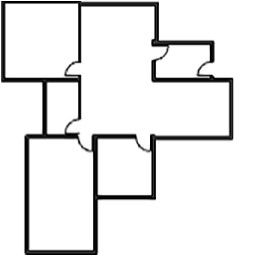

In [6]:
# 拿左邊的切法 crop(左邊座標, 上面座標, 右邊座標, 下面座標)
# 就是(0, 0, 256, 256)
left = oriimage.crop((0, 0, int(oriimage.size[0] / 2), oriimage.size[1]))
left.resize((256, 256))

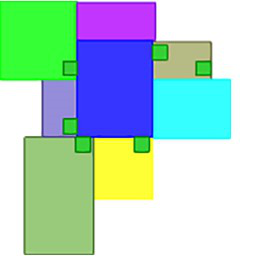

In [7]:
# 拿右邊的切法 (256, 0, 512, 256)
right = oriimage.crop((int(oriimage.size[0] / 2), 0, oriimage.size[0], oriimage.size[1]))
right.resize((256, 256))

In [0]:
# 先設定好shape方便使用
img_shape = (256, 256, 3)

In [9]:
# 鑑賞家 Discriminator
from keras.optimizers import Adam

# 因為需要很多層, 所以製造一個方便的函數
def d_layer(layer_input, filters, f_size=4):
    # 卷積 -> Leaky Relu -> BN
    # 直接使用 步長 = 2 的卷積 來代替 卷積 + 池化
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    d = BatchNormalization()(d)
    return d

# Discriminator: 一次傳 地圖 + 街景
# 地圖 + 真街景 -> 1(真)
# 地圖 + 假街景 -> 0(假)
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)
# 合併在一起, axis=-1意味著最後一個軸
# 所以每一個像素是 RGB(地圖) + RGB(街景) -> 6通道
combined_imgs = Concatenate(axis=-1)([img_A, img_B])
# 四層卷積
d1 = d_layer(combined_imgs, 64)
d2 = d_layer(d1, 128)
d3 = d_layer(d2, 256)
d4 = d_layer(d3, 512)
# 最後一層也是卷積, 特別的是filter只有1
# 因為每一個像素就一個分數就好!
validity = Conv2D(1, kernel_size=3, strides=1, padding='same')(d4)
discriminator = Model([img_A, img_B], validity)
# 使用adam的時候稍微調整一下學習速率和速度累積的幅度
optimizer = Adam(0.0002, 0.5)
discriminator.compile(loss='mse', optimizer=optimizer)
discriminator.summary()













Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 6208        concatenate_1[0

In [10]:
# 創作家 Generator

# 正向卷積: 利用地圖產生靈感
def conv2d(layer_input, filters, f_size=4):
    # 卷積 -> LeakyRelu -> BN
    # 一樣 步長 = 2 相等於 卷積 + 池化
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    d = BatchNormalization()(d)
    return d

# 反向卷積: 靈感產生假街景
def deconv2d(layer_input, skip_input, filters, f_size=4):
    # 反池化 -> 卷積 -> LeakyRelu -> BN
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same')(u)
    u = LeakyReLU(alpha=0.2)(u)
    u = BatchNormalization()(u)
    # 比較特別的是這裡, 我們說的UNet, 把對應層的特徵一起進來考慮, 產生的才不會跟原圖偏差太多
    u = Concatenate()([u, skip_input])
    return u

# (256, 256, 3)的輸入: 傳入地圖
d0 = Input(shape=img_shape)

# 正向卷積, 長寬縮小, 特徵變多
d1 = conv2d(d0, 64)
d2 = conv2d(d1, 128)
d3 = conv2d(d2, 256)
d4 = conv2d(d3, 512)
d5 = conv2d(d4, 512)
d6 = conv2d(d5, 512)
d7 = conv2d(d6, 512)
d8 = conv2d(d7, 512)

# 反向卷積, 長寬放大, 特徵變少
u0 = deconv2d(d8, d7, 512)
u1 = deconv2d(u0, d6, 512)
u2 = deconv2d(u1, d5, 512)
u3 = deconv2d(u2, d4, 512)
u4 = deconv2d(u3, d3, 256)
u5 = deconv2d(u4, d2, 128)
u6 = deconv2d(u5, d1, 64)

# 最後一次, filter數 = 3, 產生RGB圖片, activation使用tanh來產生 -1~1的圖片
u7 = UpSampling2D(size=2)(u6)
output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

generator = Model(d0, output_img)
generator.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 128, 128, 64) 256         leaky_re_lu_5[0][0]              
___________________________________________________________________________________________

In [11]:
# 組合網路
# 別忘了訓練Generator要把Discriminator接在後面, 才有所謂的GAN Loss
# img_A: 原街景
# img_B: 原地圖
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# fake_A: 假街景
fake_A = generator(img_B)

# 要把Discriminator固定住
discriminator.trainable = False

# [產生的假街景, 原地圖] 一起送進去鑑賞家判斷真假
valid = discriminator([fake_A, img_B])

# input:[原街景, 原地圖]  output:[真/假, 假地圖] for [GAN Loss, 傳統Loss]
combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])

# GAN Loss由於不是一個機率了, 所以我們改用 MSE
# 傳統 Loss可以選擇 MAE 或 MSE
# 由於 MSE 是平方, 不會一視同仁看待每一個像素, 而是差越多的懲罰愈大
# 像是把優先把分數高的拉低, 而低的不懂, 所以會比 MAE 來的模糊, 因此我們通常選擇 MAE
combined.compile(loss=['mse', 'mae'],
                 loss_weights=[1, 100],
                 optimizer=optimizer)
combined.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 256, 256, 3)  54431619    input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 16, 16, 1)    2768065     model_2[1][0]                    
                                                                 input_5[0][0]                    
Total params: 57,199,684
Trainable params: 54,420,611
Non-trainable params: 2,779,073
__________________________________________________________________________________________________


In [12]:
# 準備最後輸出的大小 (16, 16, 1)
patch = int(256 / 2**4)
disc_patch = (patch, patch, 1)
disc_patch

(16, 16, 1)

In [0]:
# 因為圖片比較大, 我們一個batch少一點
# 這裡我們準備 
# 真 的答案: 4 個 (16, 16, 1) 填滿 1
# 假 的答案: 4 個 (16, 16, 1) 填滿 0
batch_size = 4
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

In [14]:
train_count =  2000
# 5000次一輪, 我大概訓練了20輪
for train in range(0, train_count):
    # 隨機4個index來拿圖片
    rid = np.random.randint(0, len(imglist), batch_size)
    # 上面教的! 把原本訓練資料的左右切出來
    imgs_A = []
    imgs_B = []
    for i in rid:
        
        oriimage = Image.open(imglist[i])
        left = oriimage.crop((0, 0, int(oriimage.size[0] / 2), oriimage.size[1]))
        left = left.resize((256, 256))
        left = np.array(left)

        right = oriimage.crop((int(oriimage.size[0] / 2), 0, 
                               oriimage.size[0], oriimage.size[1]))
        right = right.resize((256, 256))
        right = np.array(right)

        # 圖片處理到 -1~1之間
        imgs_A.append((left - 127.5)/127.5)
        imgs_B.append((right - 127.5)/127.5)

    # 記得所有東西轉換成np array
    imgs_A = np.array(imgs_A)
    imgs_B = np.array(imgs_B)
    # 產生假街景
    fake_A = generator.predict(imgs_B)
    # Step1. 訓練鑑賞家, [原地圖 真街景] -> 1 [原地圖 假街景] -> 0
    d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
    d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Step2. 訓練創作家
    # GAN Loss:往鑑賞家心目中的1走 
    # 傳統 Loss:跟原圖越接近越好
    g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
    
    if (train + 1) % 100 == 0:
        dash = "-" * 15
        print(dash, "Train", train + 1, dash)
        print("Discriminator loss:", d_loss)
        print("Generator loss:", g_loss)



/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



--------------- Train 100 ---------------
Discriminator loss: 0.16636697947978973
Generator loss: [29.110315, 0.52577096, 0.28584546]
--------------- Train 200 ---------------
Discriminator loss: 0.04266437888145447
Generator loss: [26.574104, 0.8033389, 0.25770766]
--------------- Train 300 ---------------
Discriminator loss: 0.03879109397530556
Generator loss: [18.355495, 0.8498171, 0.17505679]
--------------- Train 400 ---------------
Discriminator loss: 0.39316022396087646
Generator loss: [15.800705, 0.8745309, 0.14926174]
--------------- Train 500 ---------------
Discriminator loss: 0.021210718899965286
Generator loss: [10.378056, 0.8990727, 0.09478983]
--------------- Train 600 ---------------
Discriminator loss: 0.05654449760913849
Generator loss: [6.6357727, 0.48160207, 0.061541706]
--------------- Train 700 ---------------
Discriminator loss: 0.0430610328912735
Generator loss: [6.1312776, 0.8302441, 0.053010337]
--------------- Train 800 ---------------
Discriminator loss: 0.

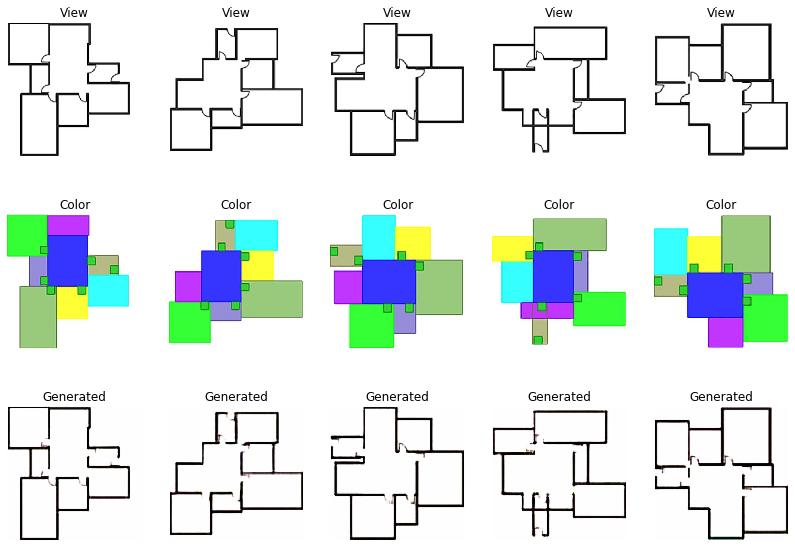

In [15]:
# 對訓練資料看看我們的模型
# 第一列: 原街景
# 第二列: 原地圖
# 第三列: 產生的街景
import random
from imageio import imread

examples = 5
plt.figure(figsize=(14, 10))

for i in range(examples):
    idx = random.randint(0, len(imglist) - 1)

    testimage = Image.open(imglist[idx])
    testleft = testimage.crop((0, 0, int(testimage.size[0] / 2), testimage.size[1]))
    testleft = testleft.resize((256, 256))
    testleft = np.array(testleft)
    testright = testimage.crop((int(testimage.size[0] / 2), 0, 
                                testimage.size[0], testimage.size[1]))
    testright = testright.resize((256, 256))
    testright = np.array(testright)

    count = i + 1
    plt.subplot(3, examples, count)
    plt.title('View')
    plt.axis('off')
    plt.imshow(testleft)
    plt.subplot(3, examples, count + examples)
    plt.title('Color')
    plt.axis('off')
    plt.imshow(testright)

    testright = (testright - 127.5)/127.5

    trans = generator.predict(np.array([testright]))
    trans = 0.5 * trans + 0.5
    plt.subplot(3, examples, count + 2 * examples)
    plt.title('Generated')
    plt.axis('off')
    plt.imshow(trans[0])

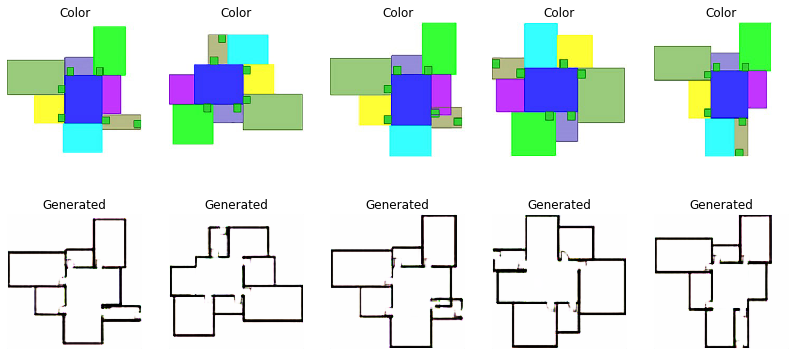

In [16]:
# 真的來預測從沒看過的資料
# 第一列: 原街景
# 第二列: 原地圖
# 第三列: 產生的街景
import random
from imageio import imread

val_imglist = glob.glob('vals/*')

examples = 5
plt.figure(figsize=(14, 10))

for i in range(examples):
    idx = random.randint(0, len(val_imglist) - 1)

    testimage = Image.open(val_imglist[idx])
    testleft = testimage.crop((0, 0, int(testimage.size[0] / 2), testimage.size[1]))
    testleft = testleft.resize((256, 256))
    testleft = np.array(testleft)
    testright = testimage.crop((int(testimage.size[0] / 2), 0, 
                                testimage.size[0], testimage.size[1]))
    testright = testright.resize((256, 256))
    testright = np.array(testright)

    count = i + 1
    plt.subplot(2, examples, count)
    #plt.title('View')
    plt.axis('off')
    plt.imshow(testleft)
    plt.subplot(3, examples, count + examples)
    plt.title('Color')
    plt.axis('off')
    plt.imshow(testright)

    testright = (testright - 127.5)/127.5

    trans = generator.predict(np.array([testright]))
    trans = 0.5 * trans + 0.5
    plt.subplot(3, examples, count + 2 * examples)
    plt.title('Generated')
    plt.axis('off')
    plt.imshow(trans[0])

In [0]:
from keras.models import load_model
generator.save('plan_model.h5')